In [1]:
from ds.data.sets import load_sets_v2
import joblib
import pandas as pd
import tensorflow as tf
from sklearn.impute import SimpleImputer
import numpy as np

2023-07-11 20:23:49.030723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(55)

In [3]:
datasets = joblib.load("../data/processed/datasetsjmone")

In [4]:
drops = [
    "review_overall",
    "beer_name",
]
for data in datasets:
    if isinstance(data, pd.DataFrame):
        for column in drops:
            if column in data.columns:
                data.drop(columns=column, inplace=True)

In [5]:
x_train, y_train, x_test, y_test, x_validation, y_validation = datasets

In [6]:
x_train

,brewery_name,review_aroma,review_appearance,review_palate,review_taste,beer_abv
590715,goose island beer co,5.0,4.5,4.0,5.0,13.00
1514329,hinterland brewery restaurant,4.0,4.0,3.5,3.5,6.85
272592,flying dog brewery,3.5,3.0,3.5,3.5,5.50
894213,stone brewing co,4.0,4.5,4.0,4.0,7.20
174214,long trail brewing co,4.0,4.0,4.0,4.0,8.60
...,...,...,...,...,...,...
759715,widmer brothers brewing company,3.5,4.5,3.0,3.5,9.40
618842,harpoon brewery,3.5,3.5,3.5,3.5,4.30
948973,bells brewery inc,3.5,3.5,3.5,3.5,5.20
678833,moorhouses brewery burnley ltd,3.5,4.0,3.0,3.5,3.40


In [7]:
x_train = x_train.fillna(-9)
x_test = x_test.fillna(-9)

In [8]:
BATCH_SIZE = 10000

In [9]:
df = x_train


In [10]:
y = y_train
y_vocab = sorted(set(y))

In [11]:
y_tensor = tf.convert_to_tensor(y, dtype=tf.string)

2023-07-11 20:23:51.089702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 20:23:51.092594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 20:23:51.092739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
# class TargetDummy(tf.keras.Model):

#   def __init__(self, vocab=None, **kwargs):
#     super().__init__(**kwargs)
#     self.vocab = vocab
#     self.lookup = tf.keras.layers.StringLookup(vocabulary=self.vocab, output_mode='one_hot')
#     if vocab is None:
#       self._vocab = vocab
#     else:
#       self._vocab = self.lookup.get_vocabulary()
#     self.invert = tf.keras.layers.StringLookup(vocabulary=self._vocab, invert=True)
  
#   def vocabulary_size(self):
#     return self.lookup.vocabulary_size()
  
#   def get_vocabulary(self):
#     return self.lookup.get_vocabulary()

#   def adapt(self, y_train):
#     self.lookup.adapt(y_train)
#     self._vocab = self.lookup.get_vocabulary()
#     self.invert.set_vocabulary(vocabulary=self._vocab)    

#   def call(self, inputs, training=False, invert=False):
#     if invert is True:
#       x = tf.argmax(inputs, axis=-1)
#       x = self.invert(x)
#     else:
#       x = self.lookup(inputs)
#       _ = self.invert(inputs)
#     return x

In [13]:
# target_model = TargetDummy(y_vocab)
# look = target_model(y_tensor)
# back = target_model(look, invert=True)
# back

In [14]:
# target_model = TargetDummy()
# test_y_tens = y_tensor[:5]
# target_model.adapt(test_y_tens)
# look = target_model(test_y_tens)
# back = target_model(look, invert=True)
# back

In [15]:
# y_input = tf.keras.Input(shape=(), dtype=tf.string)

# y_t = target_coder(y_input)
# y_output = y_t
# target_lookup = tf.keras.Model(inputs=input, outputs=y_output)

In [16]:
target_lookup = tf.keras.layers.StringLookup(vocabulary=y_vocab, output_mode='one_hot')

In [17]:
target = target_lookup(y_tensor)

In [18]:
ds = tf.data.Dataset.from_tensor_slices((dict(df), target))
ds = ds.batch(BATCH_SIZE)


In [19]:
y_test_tensor = tf.convert_to_tensor(y_test)
y_test_encoded = target_lookup(y_test_tensor)
test = tf.data.Dataset.from_tensor_slices((dict(x_test), y_test_encoded))
test = test.batch(BATCH_SIZE)

In [29]:
# ld_mdl = tf.keras.models.load_model("../models/gpu/goodmod_3")
# ld_vcb = np.load("../models/gpu/vocab_goodmod_3.npy")
# pred = ld_mdl.predict(dict(x_test))
# pred_decode = tf.keras.layers.StringLookup(vocabulary=ld_vcb, invert=True)
# pred = tf.argmax(pred, axis=-1)
# pred = pred_decode(pred)

5319/5319 [==============================] - 8s 1ms/step


In [140]:
y, idx, count = tf.unique_with_counts(y_tensor)
count = tf.cast(count, tf.float32)
total_tkns = tf.math.reduce_sum(count)
tkn_probs = count/total_tkns
log_probs = tf.math.log(tkn_probs)
vocab_size = target_lookup.vocabulary_size()
vocab = tf.convert_to_tensor(target_lookup.get_vocabulary())

init = tf.lookup.KeyValueTensorInitializer(y,log_probs)
couttbl = tf.lookup.StaticHashTable(init, default_value=-1e9)
bias_vector = tf.zeros(vocab_size,)
bias_vector = couttbl.lookup(vocab)
bias_vector[:4]

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([-1.0000000e+09, -5.0974779e+00, -3.9497817e+00, -3.5544870e+00],
      dtype=float32)>

In [141]:
bias_vector = bias_vector.numpy()

In [142]:
# #compute imputer mean
# mask = tf.where(tf.math.is_nan(tensor) , 0. , tensor)
# mask_norm = tf.reduce_sum(tf.clip_by_value(mask, 0., 1.),axis=0)
# imp_mean = tf.math.divide(tf.reduce_sum(mask, axis=0), mask_norm)

# #transform
# tf.where(tf.math.is_nan(X) , imp_mean , X)

In [143]:
numeric_feature_names = [
    # "review_overall",
    "review_aroma",
    "review_appearance",
    "review_palate",
    "review_taste",
    "beer_abv"
]
numeric_features = df[numeric_feature_names]

categorical_feature_names = [
    "brewery_name"
]

In [144]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [145]:
inputs = {}
preprocessed = []

In [146]:
for name, column in x_train.items():
  if type(column[0]) == str:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

In [147]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

In [148]:
numeric_inputs = {}
for name in numeric_feature_names:
  numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization')>]

In [149]:
for name in categorical_feature_names:
  vocab = sorted(set(df[name]))

  if type(vocab[0]) is str:
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
  else:
    lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

  x = inputs[name][:, tf.newaxis]
  x = lookup(x)
  preprocessed.append(x)

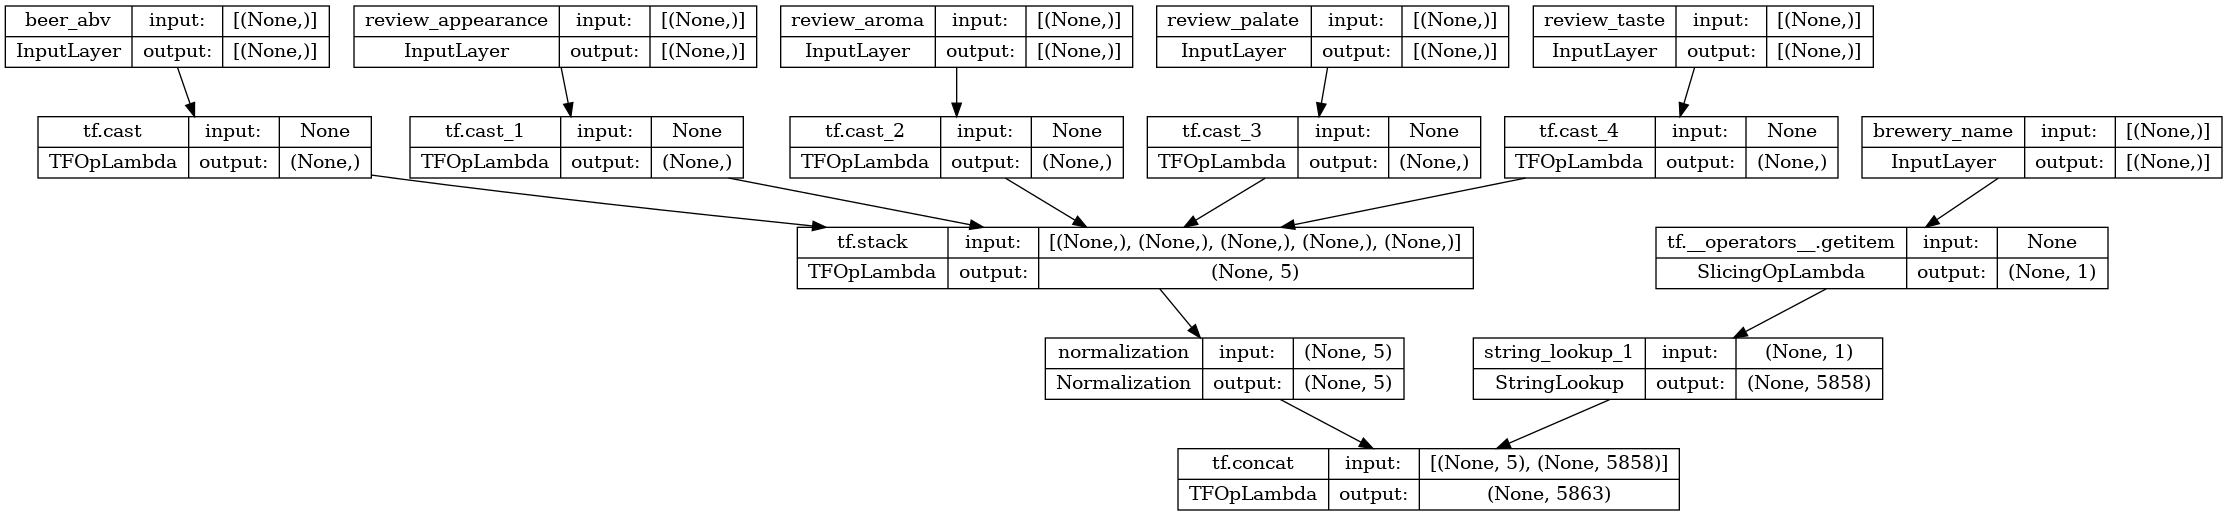

In [150]:
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocessor = tf.keras.Model(inputs, preprocesssed_result)
tf.keras.utils.plot_model(preprocessor, rankdir="TB", show_shapes=True)

In [151]:
output_bias_init = tf.keras.initializers.Constant(bias_vector)

In [171]:
body = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(target_lookup.vocabulary_size(), activation='softmax', bias_initializer=output_bias_init, name="output_layer")
    ]
)

AssertionError: Exception encountered when calling layer "model" (type Functional).

Could not compute output KerasTensor(type_spec=TensorSpec(shape=(None, 5863), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")

Call arguments received by layer "model" (type Functional):
  • inputs=tf.Tensor(shape=(None,), dtype=float32)
  • training=None
  • mask=None

In [170]:
body.layers[1].get_weights()[1].shape

(1024,)

In [153]:
x = preprocessor(inputs)
result = body(x)
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [154]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 beer_abv (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 brewery_name (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 review_appearance (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 review_aroma (InputLayer)      [(None,)]            0           []                               
                                                                                            

In [155]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.000001,
    patience=32,
    verbose=0,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=16,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=4,
    min_lr=0.00000000001
)

In [156]:
history = model.fit(
    ds,
    epochs=256,
    batch_size=BATCH_SIZE,
    validation_data=test,
    callbacks=[        
        earlystop_callback,
        reduce_lr
    ]
)

Epoch 1/256


2023-07-11 19:37:36.361438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [1361552]
	 [[{{node Placeholder/_4}}]]


136/137 [============================>.] - ETA: 0s - loss: 1.8153 - accuracy: 0.4938

2023-07-11 19:37:51.338866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype float and shape [170194,105]
	 [[{{node Placeholder/_6}}]]


137/137 [==============================] - 16s 107ms/step - loss: 1.8145 - accuracy: 0.4940 - val_loss: 3.4208 - val_accuracy: 0.2068 - lr: 0.0010
Epoch 2/256
137/137 [==============================] - 15s 106ms/step - loss: 1.0746 - accuracy: 0.6576 - val_loss: 2.3787 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 3/256
137/137 [==============================] - 14s 106ms/step - loss: 0.8996 - accuracy: 0.7031 - val_loss: 1.3441 - val_accuracy: 0.6588 - lr: 0.0010
Epoch 4/256
137/137 [==============================] - 15s 106ms/step - loss: 0.8060 - accuracy: 0.7271 - val_loss: 0.9004 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 5/256
 98/137 [====================>.........] - ETA: 3s - loss: 0.7623 - accuracy: 0.7380

KeyboardInterrupt: 

In [157]:
from pathlib import Path

def get_version_num(path):
    return int(path.stem.split("_")[-1])

In [ ]:
base_path = Path("../models/gpu/")

model_name = "goodmod"
existing_versions = base_path.glob(f"{model_name}*")
existing_versions = [get_version_num(model_path) for model_path in existing_versions]
if len(existing_versions) == 0:
    version_num = 1
else:
    version_num = max(existing_versions) + 1

this_model = f"{model_name}_{version_num}"

save_path = base_path.joinpath(this_model)

target_lookup_path = base_path.joinpath(f"vocab_{this_model}")

vocab = target_lookup.get_vocabulary()
vocab = np.array(vocab)
np.save(target_lookup_path, vocab)
# model.save(save_path, save_format="h5")


In [160]:
model.save("./testmodel")

2023-07-11 19:39:19.977005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-11 19:39:19.989299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2048]
	 [[{{node inputs}}]]
2023-07-11 19:39:20.793680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-11 19

INFO:tensorflow:Assets written to: ./testmodel/assets


In [163]:
help = tf.keras.models.load_model("./testmodel")

In [161]:
model.export("./testexpor")

ValueError: Layer "model_1" expects 6 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'args_0:0' shape=(None,) dtype=float32>]

In [162]:
testmodel = tf.keras.models.load_model("./testexpor")

OSError: No file or directory found at ./testexpor